In [1]:
import sys, os
sys.path.append(os.getcwd() + os.sep + os.pardir)

%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
np.random.seed(42)

# Dimensionality reduction and classification with Fisher's linear discriminant

In this notebook we will deal with two interesting applications of Fisher's linear discriminant: dimensionality reduction, and classification. This discriminant is formulated so that an appropriate projection of the data is found, so that the distance between points of different classes is **maximized** and the distance between points of the same class is **minimized**. The fact that it needs label information makes this a supervised learning method, in contrast to other dimensionality reduction techniques that work without labels, such as [PCA](https://dfdazac.github.io/pca_ex.html).

## The data

For illustration purposes, we will use a synthetic dataset, containing samples from two Gaussian distributions.

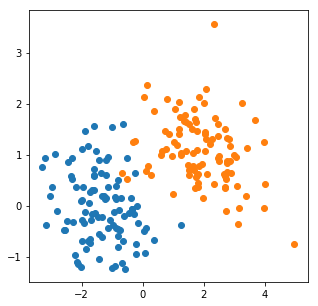

In [2]:
# Mean and covariance matrix of the distributions
mu1 = np.array([-1.5, -0.0])
cov1 = np.array([[1, -0.2], [-0.2, 0.5]])
mu2 = np.array([2, 1])
cov2 = np.array([[1, -0.2], [-0.2, 0.5]])

# Get samples and plot
data1 = np.random.multivariate_normal(mu1, cov1, 100)
data2 = np.random.multivariate_normal(mu2, cov2, 100)
plt.figure(figsize=(5, 5))
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data2[:,0], data2[:,1]);

## Projecting the data

As we introduced it, Fisher's linear discriminant is calculated so that the optimal projection that maximizes the between-class variance and minimizes the within-class variance is found. The projection is one-dimensional, which might be too extreme for some applications, but for a classification task it is useful, since we can find a threshold in the projected one-dimensional space that separates between the two classes.

In [3]:
from fisher import FisherDiscriminant

# Collect the features and labels in arrays
X = np.vstack((data1, data2))
Y = np.concatenate((np.zeros(len(data1), dtype=np.int), np.ones(len(data2), dtype=np.int)))

# Find the optimal projection
model = FisherDiscriminant()
model.fit(X, Y)
X_proj = model.transform(X)

We have projected the data, which originally lay in a two-dimensional space, to a one-dimensional space, which we stored in the `X_proj` array. We can plot a histogram of this data to observe how well the classes can be discriminated in the projected space.

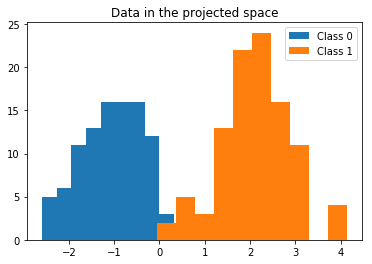

In [4]:
plt.hist(X_proj[Y == 0], label='Class 0')
plt.hist(X_proj[Y == 1], label='Class 1')
plt.legend()
plt.title('Data in the projected space');

Great! It looks as if we reduced the dimensionality of the data, and now we are able to discriminate between two classes by defining a single appropriate threshold. For this example, this threshold seems to lie between 0 and 1. Now we might ask, how do we choose the correct threshold?

## Grid-searching for the best threshold

A quick idea that comes to my mind is to split the data into training and test splits, and use the training split to find the best threshold between 0 and 1, using 4-fold cross-validation. Let's try!

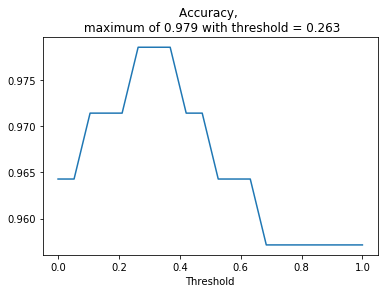

In [5]:
from data.utils import crossval_indices, split_train_test
from metrics.classification import accuracy

# Shuffle the data and split into training and test
rand_idx = np.random.permutation(len(X))
X = X[rand_idx]
Y = Y[rand_idx]
X_train, Y_train, X_test, Y_test = split_train_test(X, Y)

# Find the best threshold in the interval [0, 1)
threshold_values = np.linspace(0, 1, 20)
accuracies = np.zeros(len(threshold_values))
n_folds = 4
for i, threshold in enumerate(threshold_values):
    # Get cross-validation indices
    train_folds, valid_folds = crossval_indices(len(X_train), n_folds)
    
    acc = 0
    for train_i, valid_i in zip(train_folds, valid_folds):
        # Fit the model
        model.fit(X_train[train_i], Y_train[train_i])
        # Project validation data
        X_proj = model.transform(X_train[valid_i])        
        # Predict using the threshold
        Y_pred = np.zeros(len(Y_train[valid_i]), dtype=np.int)
        Y_pred[X_proj > threshold] = 1
        # Get accuracy
        acc += accuracy(Y_train[valid_i], Y_pred)
        
    # Calculate average accuracy
    acc /= n_folds
    accuracies[i] = acc
    
# Plot accuracy as a function of the threshold
plt.plot(threshold_values, accuracies)
max_threshold_idx = np.argmax(accuracies)
best_threshold = threshold_values[max_threshold_idx]
plt.title('Accuracy, \n maximum of {:.3f} with threshold = {:.3f}'.format(accuracies[max_threshold_idx],
                                                                  best_threshold))
plt.xlabel('Threshold');

We have obtained the best threshold that separates the data in the one-dimensional space using cross-validation. What is the final accuracy on the test set?

In [6]:
# Project test data
X_proj = model.transform(X_test)        
# Predict using the threshold
Y_pred = np.zeros(len(Y_test), dtype=np.int)
Y_pred[X_proj > best_threshold] = 1
# Get accuracy
print('Accuracy: {:.4f}'.format(accuracy(Y_test, Y_pred)))

Accuracy: 0.9833


Not bad for our toy example.

There is a second idea that we can use to solve the problem of classification with Fisher's discriminant, which is more formal, as we will now see.

## Maximum likelihood and some decision theory

If we take a look again at the histograms obtained for the projected data, we can see that the classes are normally distributed. This is the case because they come from two-dimensional Gaussian distributions. This means that instead of searching manually for a threshold, we can let the data speak to us, by finding maximum likelihood estimates of the parameters (the mean and standard deviation) of the projected distributions. It turns out that the `fit()` method of the `FisherDiscriminant` class does exactly this, so we can visualize the distributions after fitting the model.

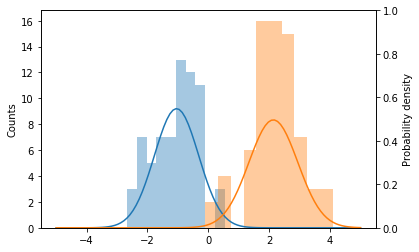

In [7]:
from scipy.stats import norm
# Fitting the model finds the optimal projection
# as well as the maximum likelihood estimates
model.fit(X_train, Y_train)
X_proj = model.transform(X_train)

# Plot histograms of projected data
fig, ax1 = plt.subplots()
ax1.hist(X_proj[Y_train == 0], label='Class 0', alpha=0.4)
ax1.hist(X_proj[Y_train == 1], label='Class 1', alpha=0.4)
ax1.set_ylabel('Counts')

# Plot estimated densities
ax2 = ax1.twinx()
x = np.linspace(-5, 5, 100)
ax2.plot(x, norm.pdf(x, loc=model.mean1, scale=model.std1))
ax2.plot(x, norm.pdf(x, loc=model.mean2, scale=model.std2))
ax2.set_ylim([0, 1])
ax2.set_ylabel('Probability density');

We can now find the best threshold using the training data by using a handy result from decision theory (see [1] for more details): the minimum misclassification rate is obtained at the intersection of the class-conditional densities, which we just found. This intersection can be found analitically and is also computed when calling the `fit()` method. Let's see what this value is.

In [8]:
model.threshold

0.4850557858306546

This is the threshold used by the `predict()` method, so we can readily make predictions for the test data and obtain the accuracy.

In [9]:
Y_pred = model.predict(X_test)
print('Accuracy: {:.4f}'.format(accuracy(Y_test, Y_pred)))

Accuracy: 0.9833


We obtain the same accuracy than with the cross-validation method, even though the threshold found with both methods is different. However, the estimation approach is preferable since the solution is found analitically instead of iterating, which saves computational resources, and also it doesn't involve setting hyperparameters.

---

## Nonlinear data

The example data we have used so far is easy because it's already linearly separable in the original space. What if we have more complicated data, like the moons dataset?

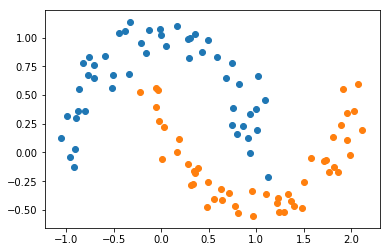

In [10]:
from sklearn.datasets import make_moons

X, Y = make_moons(100, noise=0.1)
plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1]);

Clearly there is not a line that can separate the two classes. Let's try, however, just to satisfy our curiosity.

In [11]:
# Split into training and test
X_train, Y_train, X_test, Y_test = split_train_test(X, Y)
# Train and evaluate
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print('Accuracy: {:.4f}'.format(accuracy(Y_test, Y_pred)))

Accuracy: 0.7333


We can do better than that!

We will now help the discriminant by extracting features out of the data. We will use a cubic polynomial basis to map the data to a higher dimensional space (from two dimensions up to 9). In this space, ideally the two classes will be linearly separable, so that when we project it down to a one-dimensional space using Fisher's discriminant the threshold will be more effective.

In [12]:
from features.basis_functions import polynomial_basis

# Map data to a higher dimensional space
# (The constant is dropped to avoid singular matrices)
degree = 3
X_feat = polynomial_basis(X, degree)[:, 1:]

# Split into training and test
X_train, Y_train, X_test, Y_test = split_train_test(X_feat, Y)
# Train and evaluate
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print('Accuracy: {:.4f}'.format(accuracy(Y_test, Y_pred)))

Accuracy: 0.9667


Yes! We could make this number bigger by mapping to a space of higher dimension, although we have to keep in mind that by doing so the number of features will increase, which adds to the computational cost. For now we will keep this degree and move to one last cool visualization: the decision boundary created by the polynomial basis and Fisher's discriminant.

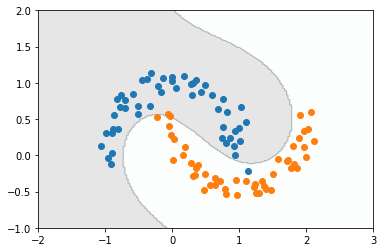

In [13]:
# Create a grid
N = 200
x1 = np.linspace(-2, 3, N)
x2 = np.linspace(-1, 2, N)
X1, X2 = np.meshgrid(x1, x2)
X_flat = np.column_stack((X1.flatten(), X2.flatten()))
# Get features
X_feat = polynomial_basis(X_flat, degree)[:, 1:]
# Evaluate model on grid
Y_pred = model.predict(X_feat).reshape(X1.shape)
plt.contourf(X1, X2, Y_pred, cmap='bone', alpha=0.1)
plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1]);

Whoa.

As we have seen, the mapping to a higher dimension gives us more flexibility on the kind of problems that we can tackle with Fisher's discriminant. There are also extensions of the discriminant for multi-class problems, which might be worth examining considering what we have seen for the binary case.

### References
[1] Bishop, Christopher M. "Pattern recognition and machine learning (information science and statistics)." (2006).